# Predicting Taxonomy

1 The taxonomy columns in the dataset contain information about the specialization or categorization of healthcare professionals (HCPs). These columns provide a hierarchical classification system that assigns specific labels or categories to HCPs based on their area of expertise or professional domain. The taxonomy labels can range from general specializations such as "General Medicine" or "Pediatrics" to more specific sub-categories like "Cardiology" or "Orthopedic Surgery." Accurately predicting the taxonomy for HCPs is crucial for understanding their professional background and tailoring healthcare services or targeted advertisements to their specific needs. However, due to the wide variety of possible taxonomy labels, predicting them accurately poses a complex and challenging task. these are encoded to codes

Installing some important libraries

In [124]:
!pip install tensorflow tensorflow_decision_forests --quiet
!pip install catboost --quiet
!pip install xgboost --quiet
!pip install category_encoders --quiet

In [259]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chi2_contingency
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from urllib.parse import urlparse
import category_encoders as ce
from google.colab import drive
from zipfile import ZipFile
import xgboost as xgb
import pandas as pd
import numpy as np
import time
import math
import re

# Small Tool used to visualizing progress nothing else

In [127]:
class progressbar:
    def __init__(self,timegap,length=40,char1='-',char2='>'):
        self.start_time = time.time()
        self.timegap=timegap
        self.time_ellapsed=0
        self.length = length
        self.char1 = char1
        self.char2 = char2
        self.data=[]
        self.extraword=''
        self.past = 0
        self.tim1 = 0
        self.past_error = 0
    def print(self,current,max,string='',clear=True,graph=False,error=0,graph_length=10,smoothing=0.2):
        assert smoothing<1
        progress=round(self.length*current/max)
        if progress == 0:
            self.past_error = error
        if time.time()-self.start_time>self.timegap:
            self.start_time = time.time()
            self.time_ellapsed+=self.timegap
            self.extraword+='\n Time taken ='+str(self.time_ellapsed)+'sec'
            if clear:
                clear_output(wait=True)
                if progress!=self.past:
                    self.tim1 = round((self.length-progress)/(progress-self.past+0.1)*self.timegap,2)
                print('['+self.char1*int(progress)+self.char2+' '*(self.length-progress)+']',
                        '\n',
                        string,
                        f"\ntime {self.tim1}s",
                        f"\ntime_spent {self.time_ellapsed}s",
                        flush=True)
                self.past = progress
            if graph:
                if len(self.data)>graph_length:
                    self.data.pop(0)
                    # print(self.data,graph_length,len(self.data))
                error = smoothing*error+(1-smoothing)*self.past_error
                self.past_error = error
                self.data.append([self.time_ellapsed,error])
                plt.plot([x[0] for x in self.data],[x[1] for x in self.data])
                plt.show()

In [128]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
# with ZipFile('/content/drive/MyDrive/Hackathon Testbiz/Correct-Complete-DataSet.zip','r') as f:
#     f.extractall()

In [130]:
df = pd.read_csv("/content/drive/MyDrive/Hackathon Testbiz/Doceree-HCP_Train.csv",encoding='ISO-8859-1')

In [131]:
df.isna().sum()

ID                     0
DEVICETYPE             0
PLATFORM_ID            0
BIDREQUESTIP           0
USERPLATFORMUID        4
USERCITY            6359
USERZIPCODE         4592
USERAGENT              2
PLATFORMTYPE           0
CHANNELTYPE            0
URL                    0
KEYWORDS               0
TAXONOMY           81624
IS_HCP                 1
dtype: int64

In [132]:
df = df.drop(['ID','CHANNELTYPE'],axis = 1)

In [133]:
df.head(2)

,DEVICETYPE,PLATFORM_ID,BIDREQUESTIP,USERPLATFORMUID,USERCITY,USERZIPCODE,USERAGENT,PLATFORMTYPE,URL,KEYWORDS,TAXONOMY,IS_HCP
0,Desktop,2,170.173.0.22,6974dcaa-f932-480e-9fb5-c52e20e1393a,Portland,97206.0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Online Medical Journal,https://www.cancertherapyadvisor.com/home/canc...,General|Endocrine|False|Medicine|Surgery|Urolo...,NaN,0.0
1,Desktop,2,65.216.253.25,c12f3f8f-8fcf-484a-90e1-1ac04db8cdcf,Arlington,22202.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Online Medical Journal,https://www.cancertherapyadvisor.com/home/deci...,Bone Marrow|Radiography|Chronic|Oncology|Psych...,NaN,0.0


In [134]:
df = df[df.IS_HCP.isna()==0].reset_index().drop('index',axis=1)

In [135]:
df = df[df.TAXONOMY.isna()==0]

In [142]:
tax_counts = df.TAXONOMY.value_counts()
Top_10_tax = tax_counts[:10].keys()

In [147]:
tax_class = Top_10_tax[0]

# Used count encoder for encoding categorical columns

In [463]:
class classify:
    def __init__(self,label):
        self.mlb = MultiLabelBinarizer()  # For keywords column
        self.clf = DecisionTreeClassifier(random_state=0) # used basic decision tree
        self.encoders = [ ce.CountEncoder(cols=['BIDREQUESTIP']),
                          ce.CountEncoder(cols=['USERPLATFORMUID']),
                          ce.CountEncoder(cols=['USERAGENT']),
                          ce.CountEncoder(cols=['USERZIPCODE']),
                          ce.CountEncoder(cols=['URL']) ,
                          ce.CountEncoder(cols=['USERCITY'])]
        self.label = label
    def fit(self,df,count=1,total=10):
        train_keys = self.mlb.fit_transform(df.KEYWORDS.apply(lambda x:set(x.lower().split('|')))) # convert to one hot encoding
        train_keys = pd.DataFrame(train_keys,columns = self.mlb.classes_)
        train_y = df.TAXONOMY.apply(lambda x:x==self.label)
        d = pd.Series(dtype=int)
        pb = progressbar(1)
        # used Cramers V correlation to findout most correlated features with target
        for ind,i in enumerate(train_keys.columns):
            pb.print(ind,len(train_keys.columns),f'{self.label} Calculating correlations {round(count/total,2)}')
            d[i] = self.cramers_v(train_keys[i],train_y)
        d = d[d.isna()==0]
        d = d[d>0]
        self.imp_cols = list(d.keys())

        self.clf.fit(train_keys,train_y)

        for encoder in self.encoders:
            df = encoder.fit_transform(df)
        train_data = pd.concat([df[['BIDREQUESTIP',
                                    'USERCITY',
                                    'USERPLATFORMUID',
                                    'USERAGENT',
                                    'USERZIPCODE',
                                    'URL']].reset_index().drop('index',axis=1),
                                train_keys[self.imp_cols]],axis=1)
        self.clf.fit(train_data,train_y)


    def predict(self,df,count=0):
        test_keys = self.mlb.transform(df.KEYWORDS.apply(lambda x:set(x.lower().split('|'))))
        test_keys = pd.DataFrame(test_keys,columns = self.mlb.classes_)
        for encoder in self.encoders:
            df = encoder.transform(df)
        test_data = pd.concat([df[['BIDREQUESTIP',
                                    'USERCITY',
                                    'USERPLATFORMUID',
                                    'USERAGENT',
                                    'USERZIPCODE',
                                    'URL']].reset_index().drop('index',axis=1),
                                test_keys[self.imp_cols]],axis=1)
        return self.clf.predict(test_data)

    def cramers_v(self,x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2, _, _, _ = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        if r-1==0 or n-1==0:
            return 0
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        corr_val = (phi2corr / min((kcorr - 1), (rcorr - 1)))
        return np.sqrt(corr_val)

In [492]:
class Taxonomy:
    def __init__(self,df,no_cols = 10):
        self.Top_cols = df.TAXONOMY.value_counts().keys()[:no_cols]
        self.df = df
        self.classifiers = [classify(label) for label in self.Top_cols]
        self.no_cols = no_cols
    def fit(self):
        for ind,classifier in enumerate(self.classifiers):
            classifier.fit(self.df,count=ind,total=self.no_cols)
    def predict(self,df):
        tax = pd.DataFrame(0,index = df.index,columns = ['Taxonomy'])
        index = tax.index
        for classifier in self.classifiers:
            preds = pd.Series(classifier.predict(df.loc[index]),index = index)
            tax.loc[preds[preds==1].index] = classifier.label
            index = preds[preds==0].index
            if len(preds[preds==0])==0:
                return tax
        return tax

In [518]:
final_test_solns = pd.read_csv('/content/submittedclasses.csv')

In [483]:
final_test_data = pd.read_csv('/content/drive/MyDrive/Hackathon Testbiz/Doceree-HCP_Test.csv')

In [486]:
test_df = final_test_data[final_test_solns.IS_HCP==1]

In [493]:
counts = df.TAXONOMY.value_counts()

<Axes: ylabel='Frequency'>

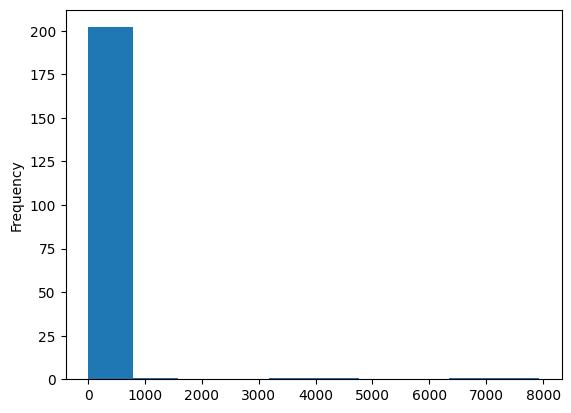

In [498]:
counts.plot.hist()

In [503]:
keys = list(counts[counts>10].keys())

In [504]:
tax = Taxonomy(df,len(keys))

In [505]:
tax.fit()

[------------------------------------->   ] 
 2085N0700X Calculating correlations 0.99 
time 1.43s 
time_spent 14s


In [508]:
preds = tax.predict(test_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['anticoagulant therapy', 'atherectomy', 'bacillary', 'blastomycosis', 'bone marrow failure disorders', 'cefpodoxime', 'celecoxib', 'early goal-directed therapy', 'gingivitis', 'hematology & oncology', 'irritability', 'mucocele', 'naproxen', 'nonvalvular atrial fibrillation', 'opportunistic infections', 'restlessness', 'tramadol', 'transient ischemic attack', 'ventricular dysfunction', 'vocal cords'] will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['anticoagulant therapy', 'atherectomy', 'bacillary', 'blastomycosis', 'bone marrow failure disorders', 'celecoxib', 'early goal-directed therapy', 'gingivitis', 'hematology & oncology', 'mucocele', 'naproxen', 'nonvalvular atrial fibrillation', 'opportunistic infections', 'tramadol', 'transient ischemic attack', 'ventricular dysfunction', 'voca

In [516]:
preds.index = test_df.index

In [520]:
final_test_solns = final_test_solns.join(preds)

In [522]:
final_test_solns.Taxonomy.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2084P0800X    2131
2084N0400X    1493
0             1218
207Q00000X     825
207R00000X     650
              ... 
204C00000X       1
207QA0401X       1
207QH0002X       1
363LA2100X       1
163WP0808X       1
Name: Taxonomy, Length: 91, dtype: int64

In [524]:
final_test_solns.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ID              0
IS_HCP          0
Taxonomy    20039
dtype: int64

In [526]:
preds.Taxonomy.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2084P0800X    2131
2084N0400X    1493
0             1218
207Q00000X     825
207R00000X     650
              ... 
204C00000X       1
207QA0401X       1
207QH0002X       1
363LA2100X       1
163WP0808X       1
Name: Taxonomy, Length: 91, dtype: int64

In [529]:
final_test_solns.to_csv('Taxonomy.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
